In [1]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram

References:
1. Quantum computing summer school lab session 2020

<h1 align="center">
<span style="color: red;">$\textbf{SHORS ALGORITHM}$</center>
</h1>

<font size='4'> Shor’s Algorithm is a quantum algorithm for integer factorisation. Simply put given an odd integer N it will find it’s prime factors.

The algorithm consists of 2 parts:

- Classical part which reduces the factorisation to a problem of finding the period of the function. This is done classically using a quantum computer

- Quantum part which uses a quantum computer to find the period using the Quantum Fourier Transform.</font>

# FINDING THE PRIME FACTORS OF A INTEGERS

 Shor's algorithm can be used to factor numbers $N$ that are products of the form 

$$N = pq$$

where $p$ and $q$ are prime numbers. 

The algorithm factors a composite integer n by selecting random integers within the range 1 < a < n, then computes the factors of n by a using Euclid's algorithm. If the GCD(a,n) > 1, then {a,n} are co-prime numbers. The Algorithm proceeds with factorization via modular exponentiation function period finding. Once even period r is found, the function calculates the first factor p = a^r/2 - 1. the second factor can be found by the formula q = a^r/2 + 1, or dividing n by the first known factor p.

There is no known efficient algorithm of period finding using the modular exponentiation function on classical computers. However, period finding problem can be solved efficiently by QC. To solve the period finding problem on a QC, the existing problem is mapped to an equivalent quantum Fourier transform (QFT) problem that returns periods of a (mod n).

Following steps is used using SHOR's Algorithm to find the prime factors of a positive integer
1. Initialize composite integer n for factoring
2. Select sample of (random) integers a
3. Verify that {a,n} are co-prime numbers via Euclidean algorithm. If GCD(a,n) > 1, first factor p = GCD(a,n), second factor q = n/p.
4.  Classical approach. If GCD(a,n) = 1, proceed with modular exponentiation period finding. Count set of unique remainders r = a^k (mod n) for each a in a sample, where order k -> 128, to avoid exceeding the range of int64. Compute period r.
5.  Quantum approach - Estimate period r(a) by mapping the problem into QFT. Convert {a,n} into binary, construct the quantum circuit of n + 1 qubits, where additional qubit serves as the q-control for recycling the output of sequential circuits.
6. If r is even, calculate factor p = a^r/2 - 1.
7. Calculate second factor q = n/p
8. (Optional) Check if p and q are prime by initializing them as the input n in the first stage of the algorithm.

<h1 align="center">
<span style="color: blue;">$\textbf{Classically finding the period of modulo function}$</center>
</h1>

<img src="Images/shors1.jpg" alt="drawing" width="600"/>

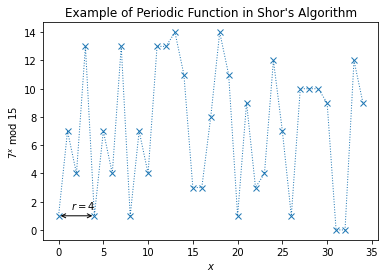

In [2]:
N=15
a=7
import numpy as np
# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')
    

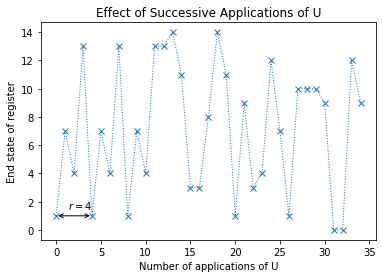

In [3]:
ax.set(xlabel='Number of applications of U', ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

<h1 align="center">
<span style="color: blue;">$\textbf{Finding the period of modulo function using QC}$</center>
</h1>

### 1. Initializing the qubits

We will need to initialize our qubits as described above by applying a Hadamard gate on each of the $n$ measurement qubits. We will also set the target qubits to $\vert1\rangle$, since that is the eigenstate onto which the unitary operator $U$ will be applied. Here, $\vert1\rangle$ is initialized by applying an $X$ gate on the last qubit.

In [4]:
def initialize_qubits(given_circuit, n, m):
    given_circuit.h(range(n))
    given_circuit.x(3+m)    

### 2. Modular exponentiation

We have created a function called `a_x_mod15` below which takes in two arguments, `a` and `x`, and implements the unitary operator $$U = a^x \text{ mod } 15$$

In [5]:
def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, x)
    c_U = U.control()
    return c_U

In [6]:
def modular_exponentiation(given_circuit, n, m, a):
    for g in range(n):
        given_circuit.append(a_x_mod15(a,2**g),[g]+[i+n for i in range(m)])
   
    

### 3. Implementing the inverse quantum Fourier transform

The last step before measuring the first $n$ qubits is the implementation of the inverse quantum Fourier transform. 

The function `apply_iqft` takes two arguments. The first argument, `given_circuit`, contains the qubits onto which the inverse quantum Fourier transform will be applied. The second argument, `measurement_qubits`, contains the list of qubits onto which the inverse quantum Fourier transform will be applied.

In [7]:
from qiskit.circuit.library import QFT
def apply_iqft(given_circuit, measurement_qubits):
    gate = QFT(len(measurement_qubits) ,inverse=True, do_swaps=False, name='iqft')
    given_circuit.append(gate,range(len(measurement_qubits)))

### 4. Putting it all together

Finally, we combine the functions to construct the quantum program that implements Shor's algorithm.

In [8]:
def shor_program(n, m, a):
    
    # set up quantum circuit
    shor = QuantumCircuit(n+m, n)
    
    # initialize the qubits
    initialize_qubits(shor, n, m)
    shor.barrier()

    # apply modular exponentiation
    modular_exponentiation(shor, n, m, a)
    shor.barrier()

    # apply inverse QFT
    apply_iqft(shor, range(n))

    # measure the first n qubits
    shor.measure(range(n), range(n))
    
    return shor
    
n = 4; m = 4; a = 7
mycircuit = shor_program(n, m, a)
mycircuit.draw(output='text')

┌───┐ ░                                                              ░ »
q_0: ┤ H ├─░────────■─────────────────────────────────────────────────────░─»
     ├───┤ ░        │                                                     ░ »
q_1: ┤ H ├─░────────┼──────────────■──────────────────────────────────────░─»
     ├───┤ ░        │              │                                      ░ »
q_2: ┤ H ├─░────────┼──────────────┼──────────────■───────────────────────░─»
     ├───┤ ░        │              │              │                       ░ »
q_3: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────■────────░─»
     └───┘ ░ ┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐ ░ »
q_4: ──────░─┤0     │      ├┤0     │      ├┤0     │      ├┤0     │      ├─░─»
           ░ │             ││             ││             ││             │ ░ »
q_5: ──────░─┤1            ├┤1            ├┤1            ├┤1            ├─░─»
           ░ │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 │ ░ »
q_6: ──────░─┤2            ├┤2            ├┤2            ├┤2            ├─░─»
     ┌───┐ ░ │             ││             ││             ││             │ ░ »
q_7: ┤ X ├─░─┤3            ├┤3            ├┤3            ├┤3            ├─░─»
     └───┘ ░ └─────────────┘└─────────────┘└─────────────┘└─────────────┘ ░ »
c_0: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_1: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_2: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_3: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───────┐┌─┐         
«q_0: ┤0      ├┤M├─────────
«     │       │└╥┘┌─┐      
«q_1: ┤1      ├─╫─┤M├──────
«     │  iqft │ ║ └╥┘┌─┐   
«q_2: ┤2      ├─╫──╫─┤M├───
«     │       │ ║  ║ └╥┘┌─┐
«q_3: ┤3      ├─╫──╫──╫─┤M├
«     └───────┘ ║  ║  ║ └╥┘
«q_4: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«q_5: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«q_6: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«q_7: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«c_0: ══════════╩══╬══╬══╬═
«                  ║  ║  ║ 
«c_1: ═════════════╩══╬══╬═
«                     ║  ║ 
«c_2: ════════════════╩══╬═
«                        ║ 
«c_3: ═══════════════════╩═
«

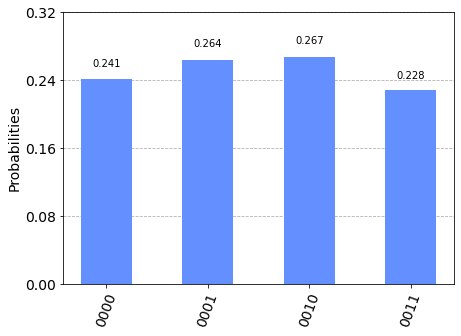

In [9]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator, shots=1000).result().get_counts(mycircuit)
plot_histogram(counts)

In [10]:
for measured_value in counts:
    print(f"Measured {int(measured_value[::-1], 2)}")

Measured 4
Measured 0
Measured 8
Measured 12


<img src="Images/shors2.jpg" alt="drawing" width="600"/>
<img src="Images/shors3.jpg" alt="drawing" width="600"/>

### Since the differences between these sucessive number after arranging in ascending order or descending is 4 which is the value of r

<h1 align="center">
<span style="color: blue;">$\textbf{Classical post-processing}$</center>
</h1>

Recall that in order to factor the number $N = pq$, we used a number $a$ coprime with $N$ and computed the period of $a^x \text{ mod } N$.

We will use the sequence of steps outlined in lecture 4 to guess the factors of $N$ using the measurement outcomes.

In [11]:
from math import gcd

for measured_value in counts:
    measured_value_decimal = int(measured_value[::-1], 2)
    print(f"Measured {measured_value_decimal}")
    
    if measured_value_decimal % 2 != 0:
        print("Failed. Measured value is not an even number")
        continue
    x = int((a ** (measured_value_decimal/2)) % 15)
    if (x + 1) % 15 == 0:
        print("Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)")
        continue
    guesses = gcd(x + 1, 15), gcd(x - 1, 15)
    print(guesses)

Measured 4
(5, 3)
Measured 0
(1, 15)
Measured 8
(1, 15)
Measured 12
(5, 3)


### Hence the prime factors for a positive integer 15 is either (1,15) or (3,5)

<h1 align="center">
<span style="color: blue;">FOR FINDING THE PRIME FACTORS OF ANY INTEGER USING  QISKIT ALGORITM CALLED Shor(N)</center>
</h1>


In [ ]:
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import Shor

IBMQ.enable_account('51604a639fe9f00db8ecdab8de97007873edfa4210dc51c5bbb566ef289a98da0071d3bbd852b5df450ffa56e93dc9bb22cf7606b8e1dfaa35aea5dbb9abbdbb') # Enter your API token here
provider = IBMQ.get_provider(hub='ibm-q')

backend = provider.get_backend('ibmq_qasm_simulator') # Specifies the quantum device

print('\n Shors Algorithm')
print('--------------------')
print('\nExecuting...\n')

factors = Shor(35) #Function to run Shor's algorithm where 21 is the integer to be factored

result_dict = factors.run(QuantumInstance(backend, shots=1, skip_qobj_validation=False))
result = result_dict['factors'] # Get factors from results

print(result)
print('\nPress any key to close')
input()

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:109: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '



 Shors Algorithm
--------------------

Executing...

[]

Press any key to close
